In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

tweets = pd.read_csv('BrandTweets.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
tweets.head()

,id,Brand,created_at,favorite_count,retweet_count,text
0,829484931701145600,audi,Thu Feb 09 00:19:53 +0000 2017,0.0,0.0,Great brand positioning! #Audi Super Bowl ad m...
1,829484460286603265,audi,Thu Feb 09 00:18:01 +0000 2017,0.0,0.0,That #Audi commercial is so awful.
2,829481014141517826,audi,Thu Feb 09 00:04:19 +0000 2017,0.0,0.0,"Watch ""Parody Audi Super Bowl Commercial"" on Y..."
3,829480810956935171,audi,Thu Feb 09 00:03:30 +0000 2017,0.0,124.0,RT @USATODAYsports: Audi #SuperBowl commercial...
4,829478177634410497,audi,Wed Feb 08 23:53:03 +0000 2017,0.0,0.0,Whats a woman's worth? Great advertisement for...


In [3]:
tweets['Brand'] = tweets['Brand'].replace(to_replace="Mr.%20Clean",value="Mr. Clean")
tweets['Brand'].value_counts()

coke         2000
Mr. Clean    1258
budweiser     998
ford          591
audi          288
Name: Brand, dtype: int64

In [4]:
def get_brand_df(brand):
    '''Based on brand keyword, return a cleaned dataframe for that brand'''
    brand_subset = tweets[tweets['Brand'] == brand]
    
    # Remove duplicate rows for retweets
    brand_subset = brand_subset.drop_duplicates(subset = 'text')
    
    # Create percentage of all retweets column
    brand_subset['retweet_pct'] = 1.0*brand_subset['retweet_count']/sum(brand_subset['retweet_count'])
    
    return brand_subset

In [5]:
def tokenize_tweet(tweet,brand_stops):
    '''Takes a tweet and brand stop words and returns a list of tokens.'''
    
    tweet = tweet.decode("utf8")
    
    # Create list of punctuation and "stop words" to remove
    punctuations = list(string.punctuation)
    commercial_stop_words = ['\'s','...','\'\'','``','n\'t','https','rt','commercial','super','bowl','superbowl','via']
    stops = punctuations+commercial_stop_words+brand_stops    
        
    # Tokenize tweet
    tokens = word_tokenize(tweet)
    
    # Remove stop words and punctuation
    tokens_stop = [word.lower() for word in tokens if word.lower() not in stopwords.words('english')]
    tokens_stop2 = [word.lower() for word in tokens_stop if word.lower() not in stops]
    
    # Remove quotation marks from tokens
    tokens = []
    
    for token in tokens_stop2:
        token = token.replace('"', "")
        token = token.replace("'", "")
        tokens.append(token)
    
    # Lemmatize tokens
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(token) for token in tokens]
          
    return tokens

In [6]:
def SentiRate(tokens_list, senti_dict):
    '''Takes list of tokens and returns a cumulative sentiment score for the entire list'''
    
    list_score = 0
    
    for token in tokens_list:
        if token in senti_dict.keys():
            token_score = senti_dict[token]
            list_score += token_score
    
    return list_score

In [7]:
def get_senti_scores_RT(tweets_list, RTcounts_list, brand_stops, senti_dict):
    '''Takes list of tweets and list of retweet counts for each tweet,
    returns a series of sentiment scores corresponding to the tweets'''
    
    # Initialize list
    senti_list = []
    
    # Loop through tweets
    for i in range(len(tweets_list)):
        tweet = tweets_list[i]
        retweet_count = int(RTcounts_list[i])
        
        # Tokenize tweet
        tokens = tokenize_tweet(tweet, brand_stops)
        
        # Get sentiment score for tweet
        tweet_score = SentiRate(tokens, senti_dict)
        
        # Add sentiment to list (once for original tweet, once for each retweet)
        senti_list.append(tweet_score)
        for j in range(retweet_count):
            senti_list.append(tweet_score)
    
    senti_series = pd.Series(senti_list)
    
    return senti_series

In [8]:
def get_senti_scores(tweets_list, brand_stops, senti_dict):
    '''Takes list of tweets and list of retweet counts for each tweet,
    returns a series of sentiment scores corresponding to the tweets'''
    
    # Initialize list
    senti_list = []
    
    # Loop through tweets
    for i in range(len(tweets_list)):
        tweet = tweets_list[i]
        
        # Tokenize tweet
        tokens = tokenize_tweet(tweet, brand_stops)
        
        # Get sentiment score for tweet
        tweet_score = SentiRate(tokens, senti_dict)
        
        # Add sentiment to list (once for original tweet)
        senti_list.append(tweet_score)
    
    senti_series = pd.Series(senti_list)
    
    return senti_series

In [9]:
lmtzr = WordNetLemmatizer()

In [10]:
# Create sentiment score dictionary
SentiStrength_scores = pd.read_csv("SentiStrength_Dict.csv")
del SentiStrength_scores['Unnamed: 2']
SentiStrength_scores['word'].apply(lmtzr.lemmatize)
SentiStrength_scores['word'] = [word.decode("utf8") for word in SentiStrength_scores['word']]
senti_dict = SentiStrength_scores.set_index('word')['score'].to_dict()

# Coca-Cola: "It's Beautiful"

In [11]:
coke = get_brand_df('coke').reset_index().drop('index', axis=1)
coke_stops = ['coke','cocacola','coca-cola']
coke_tweets = coke['text'].tolist()
coke_RT = coke['retweet_count'].tolist()

"Beautiful" is a word that receives a high sentiment score. However, since it is in both the title of the commercial and the title of the song in the commercial, it is likely that many tweets used the word merely to reference these titles rather than to describe their sentiment. Let's change its sentiment score to 0 to account for this possibility. 

In [12]:
coke_senti_dict = senti_dict
coke_senti_dict['beautiful'] = 0

### Retweets Included

In [13]:
coke_RTscores = get_senti_scores_RT(coke_tweets, coke_RT, coke_stops, coke_senti_dict)

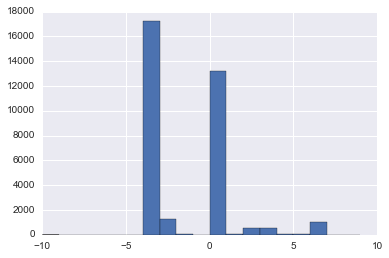

In [14]:
count, division = np.histogram(coke_RTscores, bins = range(-10,10))
coke_RTscores.hist(bins=division)

In [15]:
coke_RTsummary = coke_RTscores.describe()
coke_RTsummary

count    34059.000000
mean        -1.870255
std          2.512273
min        -10.000000
25%         -4.000000
50%         -4.000000
75%          0.000000
max          9.000000
dtype: float64

### Retweets Not Included

In [16]:
coke_scores = get_senti_scores(coke_tweets, coke_stops, coke_senti_dict)

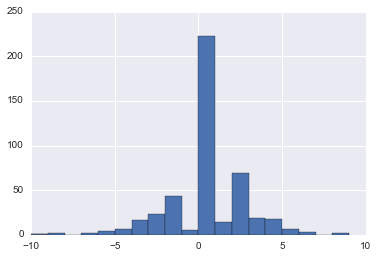

In [17]:
count, division = np.histogram(coke_scores, bins = range(-10,10))
coke_scores.hist(bins=division)

In [18]:
coke_summary = coke_scores.describe()
coke_summary

count    458.000000
mean       0.039301
std        2.340441
min      -10.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        9.000000
dtype: float64

---

# Mr. Clean: "Cleaner of Your Dreams"

In [19]:
mrclean = get_brand_df('Mr. Clean').reset_index().drop('index', axis=1)
clean_stops = ['clean','mr','mr.','mr.clean','mrclean']
clean_tweets = mrclean['text'].tolist()
clean_RT = mrclean['retweet_count'].tolist()

### Retweets Included

In [20]:
clean_RTscores = get_senti_scores_RT(clean_tweets, clean_RT, clean_stops, senti_dict)

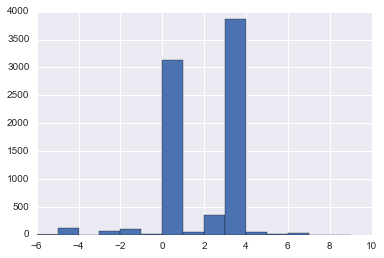

In [21]:
count, division = np.histogram(clean_RTscores, bins = range(-6,10))
clean_RTscores.hist(bins=division)

In [22]:
clean_RTsummary = clean_RTscores.describe()
clean_RTsummary

count    7815.000000
mean        1.503647
std         1.800650
min        -6.000000
25%         0.000000
50%         3.000000
75%         3.000000
max         9.000000
dtype: float64

### Retweets Not Included

In [23]:
clean_scores = get_senti_scores(clean_tweets, clean_stops, senti_dict)

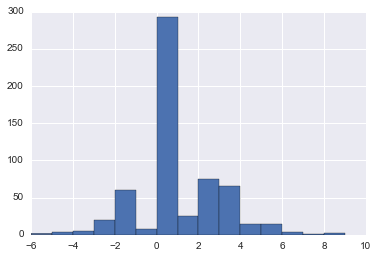

In [24]:
count, division = np.histogram(clean_scores, bins = range(-6,10))
clean_scores.hist(bins=division)

In [25]:
clean_summary = clean_scores.describe()
clean_summary

count    594.000000
mean       0.526936
std        2.002557
min       -6.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        9.000000
dtype: float64

---

# Budweiser: "Born the Hard Way"

In [26]:
budweiser = get_brand_df('budweiser').reset_index().drop('index', axis=1)
bud_stops = ['budweiser']
bud_tweets = budweiser['text'].tolist()
bud_RT = budweiser['retweet_count'].tolist()

### Retweets Included

In [27]:
bud_RTscores = get_senti_scores_RT(bud_tweets, bud_RT, bud_stops, senti_dict)

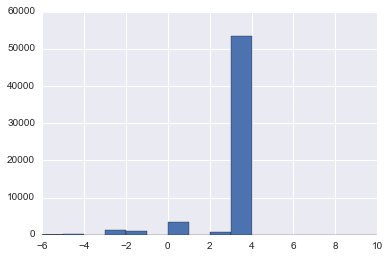

In [28]:
count, division = np.histogram(bud_RTscores, bins = range(-6,11))
bud_RTscores.hist(bins=division)

In [29]:
bud_RTsummary = bud_RTscores.describe()
bud_RTsummary

count    60374.000000
mean         2.564879
std          1.365952
min         -6.000000
25%          3.000000
50%          3.000000
75%          3.000000
max         10.000000
dtype: float64

### Retweets Not Included

In [30]:
bud_scores = get_senti_scores(bud_tweets, bud_stops, senti_dict)

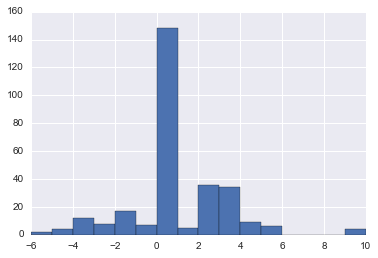

In [31]:
count, division = np.histogram(bud_scores, bins=range(-6,11))
bud_scores.hist(bins=division)

In [32]:
bud_summary = bud_scores.describe()
bud_summary

count    292.000000
mean       0.479452
std        2.339616
min       -6.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       10.000000
dtype: float64

---

# Compare Results

### Retweets Included

In [33]:
brands_RTsummary = pd.concat([coke_RTsummary, clean_RTsummary, bud_RTsummary], axis=1)
brands_RTsummary.columns = ['Coca-Cola (RT included)', 'Mr. Clean (RT included)', 'Budweiser (RT included)']
brands_RTsummary

,Coca-Cola (RT included),Mr. Clean (RT included),Budweiser (RT included)
count,34059.000000,7815.000000,60374.000000
mean,-1.870255,1.503647,2.564879
std,2.512273,1.800650,1.365952
min,-10.000000,-6.000000,-6.000000
25%,-4.000000,0.000000,3.000000
50%,-4.000000,3.000000,3.000000
75%,0.000000,3.000000,3.000000
max,9.000000,9.000000,10.000000


### Retweets Not Included

In [34]:
brands_summary = pd.concat([coke_summary, clean_summary, bud_summary], axis=1)
brands_summary.columns = ['Coca-Cola', 'Mr. Clean', 'Budweiser']
brands_summary

,Coca-Cola,Mr. Clean,Budweiser
count,458.000000,594.000000,292.000000
mean,0.039301,0.526936,0.479452
std,2.340441,2.002557,2.339616
min,-10.000000,-6.000000,-6.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000
max,9.000000,9.000000,10.000000
